In [1]:
import os

current_dir = os.getcwd()
print("Current directory:", current_dir)


Current directory: c:\KimBS\AI_Boot\project1\project1\Project1\model\steel_model\1st


In [92]:
import time 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

# 업샘플링에 사용되는 라이브러리
from imblearn.over_sampling import ADASYN


In [3]:
# 모든 컬럼을 출력할 수 있도록 설정
pd.set_option('display.max_columns', None)

path = '../../../data/steel.csv'

df = pd.read_csv(path)
df.head()


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


### 전처리 진행


In [4]:
# 일단 카피
df_clear = df.copy()
# 타겟특성 빼고 변수에 저장
df_clear = df_clear.drop(df_clear.iloc[:, -7:].columns, axis=1)
# Area라는 컬럼 생성
df_clear['Area'] = (df['X_Maximum'] - df['X_Minimum']) * \
    (df['Y_Maximum'] - df['Y_Minimum'])
# Area컬럼을 생성하는데 사용된 피쳐 제거(X_Maximum, X_Minimum, Y_Maximum, Y_Minimum)
df_clear = df_clear.drop(df.iloc[:, :4].columns, axis=1)
# A300 제거(300 or 400이라 하나 제거 후 컬럼명 어떻게 할지 고민)
df_clear = df_clear.drop('TypeOfSteel_A300', axis=1)
# 일단 TypeOfSteel로만 변경해서 설명란에 0은 300 1은 400으로 해보기로
df_clear.rename(columns={'TypeOfSteel_A400': 'TypeOfSteel'}, inplace=True)
# Log_X_index, Log_Y_index 제거 LogOFAreas가 합친결과값으로 판단되어 제거하기로 함
df_clear = df_clear.drop(['Log_X_Index', 'Log_Y_Index'], axis=1)
df_clear = df_clear.drop('Outside_Global_Index', axis=1)
display(df_clear.shape)
df_clear.head()


(1941, 20)

,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,LogOfAreas,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Area
0,267,17,44,24220,76,108,1687,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,2.4265,0.8182,-0.2913,0.5822,352
1,108,10,30,11397,84,123,1687,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,2.0334,0.7931,-0.1756,0.2984,174
2,71,8,19,7972,99,125,1623,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.8513,0.6667,-0.1228,0.2150,108
3,176,13,45,18996,99,126,1353,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,2.2455,0.8444,-0.1568,0.5212,315
4,2409,60,260,246930,37,126,1353,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,3.3818,0.9338,-0.1992,1.0000,4369


In [5]:
df_clear.describe()


,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,LogOfAreas,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Area
count,1941.000000,1941.000000,1941.000000,1.941000e+03,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1.941000e+03
mean,1893.878413,111.855229,82.965997,2.063121e+05,84.548686,130.193715,1459.160227,0.599691,78.737764,0.331715,0.414203,0.570767,0.033361,0.610529,0.813472,2.492388,0.083288,-0.131305,0.585420,5.464301e+03
std,5168.459560,301.209187,426.482879,5.122936e+05,32.134276,18.690992,144.577823,0.490087,55.086032,0.299712,0.137261,0.271058,0.058961,0.243277,0.234274,0.788930,0.500868,0.148767,0.339452,6.271009e+04
min,2.000000,2.000000,1.000000,2.500000e+02,0.000000,37.000000,1227.000000,0.000000,40.000000,0.000000,0.000000,0.008300,0.001500,0.014400,0.048400,0.301000,-0.991000,-0.998900,0.119000,2.000000e+00
25%,84.000000,15.000000,13.000000,9.522000e+03,63.000000,124.000000,1358.000000,0.000000,40.000000,0.060400,0.315800,0.361300,0.006600,0.411800,0.596800,1.924300,-0.333300,-0.195000,0.248200,1.360000e+02
50%,174.000000,26.000000,25.000000,1.920200e+04,90.000000,127.000000,1364.000000,1.000000,70.000000,0.227300,0.412100,0.555600,0.010100,0.636400,0.947400,2.240600,0.095200,-0.133000,0.506300,3.060000e+02
75%,822.000000,84.000000,83.000000,8.301100e+04,106.000000,140.000000,1650.000000,1.000000,80.000000,0.573800,0.501600,0.818200,0.023500,0.800000,1.000000,2.914900,0.511600,-0.066600,0.999800,1.610000e+03
max,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,253.000000,1794.000000,1.000000,300.000000,0.995200,0.943900,1.000000,0.875900,1.000000,1.000000,5.183700,0.991700,0.642100,1.000000,2.721150e+06


In [6]:
# 정규분포를 위한 log 변환

log_list = ['X_Perimeter',
            'Y_Perimeter',
            'Steel_Plate_Thickness',
            # 'Edges_Index', # <- 0이 들어있어서 로그변환이 안됨 zerodivision_error
            'Outside_X_Index',
            'Area',
            'Edges_Y_Index',
            'Pixels_Areas',
            'Sum_of_Luminosity']

for i in log_list:
    df_clear[i] = np.log(df_clear[i])


In [7]:
df_clear.head()


,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,LogOfAreas,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Area
0,5.587249,2.833213,3.784190,10.094934,76,108,1687,0,4.382027,0.0498,0.2415,0.1818,-5.360193,0.4706,0.000000,2.4265,0.8182,-0.2913,0.5822,5.863631
1,4.682131,2.302585,3.401197,9.341105,84,123,1687,0,4.382027,0.7647,0.3793,0.2069,-5.626821,0.6000,-0.033867,2.0334,0.7931,-0.1756,0.2984,5.159055
2,4.262680,2.079442,2.944439,8.983691,99,125,1623,0,4.605170,0.9710,0.3426,0.3333,-5.599422,0.7500,-0.054034,1.8513,0.6667,-0.1228,0.2150,4.682131
3,5.170484,2.564949,3.806662,9.851984,99,126,1353,1,5.669881,0.7287,0.4413,0.1556,-5.259097,0.5385,0.000000,2.2455,0.8444,-0.1568,0.5212,5.752573
4,7.786967,4.094345,5.560682,12.416860,37,126,1353,1,5.220356,0.0695,0.4486,0.0662,-4.374058,0.2833,-0.011567,3.3818,0.9338,-0.1992,1.0000,8.382289


In [8]:
y_list = list(df.iloc[:, -7:].columns)
df_target = df.copy()
df_target["Type"] = df_target.loc[:, y_list][y_list].idxmax(axis=1)
df_target = df_target.drop(columns=y_list)
display(df_target['Type'].value_counts())


Other_Faults    673
Bumps           402
K_Scatch        391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
Name: Type, dtype: int64

In [9]:
# 이진분류를 위한 'Type' 컬럼 값 수정
df_target1 = df_target.copy()
df_target1['Type'] = df_target1['Type'].apply(
    lambda x: 1 if x != 'Other_Faults' else 0)
df_target1['Type'].value_counts(normalize=True)


1    0.653272
0    0.346728
Name: Type, dtype: float64

In [10]:
# 다중분류를 위한 'Type' 컬럼 값 수정
df_target2 = df_target.copy()
# 'Other_Faults'를 제외한 인덱스 가져오기
indices_to_remove = df_target2[df_target2['Type'] == 'Other_Faults'].index
# 해당 인덱스들을 제거하여 새로운 데이터프레임 생성
df_clear2 = df_clear.copy()
df_clear2 = df_clear.drop(indices_to_remove)
# 'Other_Faults' 행을 제외하고 결함이 있는 것만 남기기
df_target2 = df_target2[df_target2['Type'] != 'Other_Faults']
display(df_target2['Type'].value_counts(normalize=True))
encoder = LabelEncoder()
df_target2['Type'] = encoder.fit_transform(df_target2['Type'])
display(df_target2['Type'].value_counts(normalize=True))
# 라벨 인코딩된 값에 해당하는 원래 범주 확인
for encoded, original in enumerate(encoder.classes_):
    print(f"{encoded} -> {original}")


Bumps        0.317035
K_Scatch     0.308360
Z_Scratch    0.149842
Pastry       0.124606
Stains       0.056782
Dirtiness    0.043375
Name: Type, dtype: float64

0    0.317035
2    0.308360
5    0.149842
3    0.124606
4    0.056782
1    0.043375
Name: Type, dtype: float64

0 -> Bumps
1 -> Dirtiness
2 -> K_Scatch
3 -> Pastry
4 -> Stains
5 -> Z_Scratch


#### Base model 성능

[Epoch 10, lr 0.001]<br>

[Train Dataset] Loss = 16.039, Accuracy = 0.303<br>

[Test Dataset] Accuracy = 0.412<br>


#### 모델링 순서

- 크게 두가지 scaler 중 택 1(Standard, MinMax)
- 오버샘플링 할지 안할지 택 1
- 팀원분과 나누어서 분류모델로 RandomForest, Xgboost 모델 사용
- 별 모델 만들때 쓴 함수 가져와서 사용하기(ipynb파일이라 그냥 복사 붙여넣기로 가져옴...) -> 내용이 조금 달라서 수정
- 이진분류를 진행하고 다중분류를 진행하려 하기에 타겟값을 두종류로 나누어 모델 2개를 생성해야함


In [11]:
# 별 모델과 다르게 x_df, y_df를 매개변수로 적어두고 사용 -> x, y를 미리 나누어두고 진행해야해서..

def split_dataset(x_df, y_df, test_ratio=0.2, select=1, upsampling=None):
    # 미리 전역변수로 설정해두기
    global scaler

    x_train, x_test, y_train, y_test = train_test_split(
        x_df, y_df, test_size=test_ratio, random_state=42, stratify=y_df)

    # 대표적인 표준화 두가지 중 택1
    if select == 1:
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()

    # 타겟이 불균형하므로 오버샘플링을 해보기(매개변수를 지정안해주면 None이 실행되므로 if문에 안들어감 2가지 방법 실험용)
    # 스모트(SMOTE) 대신에 아다신(ADASYN) 사용된 이유는 좀 더 랜덤하게 업스케일링이 되게 하게 위해 사용
    if upsampling:
        adasyn = ADASYN(random_state=42)
        x_train, y_train = adasyn.fit_resample(x_train, y_train)

    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    x_train = pd.DataFrame(x_train, columns=x_df.columns)
    x_test = pd.DataFrame(x_test, columns=x_df.columns)

    return x_train, x_test, y_train, y_test


In [12]:
def get_metrics(model, x_train, y_train):

    # 교차 검증 수행 및 평가 지표 계산
    scoring = {
        'accuracy': 'accuracy',
        'recall': make_scorer(recall_score),
        'precision': make_scorer(precision_score),
        'f1_score': make_scorer(f1_score)
    }
    # 훈련 평가지표 출력
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    print("훈련 정확도: ", model.score(x_train, y_train))
    print("훈련 recall: ", recall_score(y_train, y_pred))
    print("훈련 Precision: ", precision_score(y_train, y_pred))
    print("훈련 F1-score: ", f1_score(y_train, y_pred))

    # 교차검증 5개로 분할
    cv_results = cross_validate(model, x_train, y_train, cv=5, scoring=scoring)

    # 교차 검증 결과를 데이터프레임으로 변환
    cv_results_df = pd.DataFrame(cv_results)

    # 평균값을 추가한 새로운 행을 생성하여 데이터프레임에 추가
    mean_scores = cv_results_df.mean().to_frame().T
    mean_scores.rename(index={0: 'mean'}, inplace=True)
    cv_results_df = pd.concat([cv_results_df, mean_scores], axis=0)

    return cv_results_df


### 이진분류 모델 start!!!

- df_clear, df_target1['Type'] 각 x, y로 사용
- 이진분류와 다중분류 모델을 각각 생성해야 함... 시간이 얼마나 걸릴지.. ㅎㅎ


In [13]:
df_clear.shape, df_target1['Type'].shape, df_clear2.shape, df_target2['Type'].shape


((1941, 20), (1941,), (1268, 20), (1268,))

- x_train1 생성하기
- select=1 로 설정하여 StandardScaler 사용 oversampling X
- 별모델과 똑같이 다양성을 위해 ADASYN 사용


In [14]:
x_train1, x_test1, y_train1, y_test1 = split_dataset(
    df_clear, df_target1['Type'], test_ratio=0.2, select=1, upsampling=None)


In [15]:
print('훈련 데이터 shape:', x_train1.shape, y_train1.shape)
print('테스트 데이터 shape:', x_test1.shape, y_test1.shape)


훈련 데이터 shape: (1552, 20) (1552,)
테스트 데이터 shape: (389, 20) (389,)


In [16]:
print(y_train1.value_counts(normalize=True))
y_test1.value_counts(normalize=True)


1    0.653351
0    0.346649
Name: Type, dtype: float64


1    0.652956
0    0.347044
Name: Type, dtype: float64

- x_train2 생성
- select=1 로 설정하여 StandardScaler 사용 oversampling O


In [17]:
x_train2, x_test2, y_train2, y_test2 = split_dataset(
    df_clear, df_target1['Type'], test_ratio=0.2, select=1, upsampling=1)


In [18]:
print('훈련 데이터 shape:', x_train2.shape, y_train2.shape)
print('테스트 데이터 shape:', x_test2.shape, y_test2.shape)


훈련 데이터 shape: (1989, 20) (1989,)
테스트 데이터 shape: (389, 20) (389,)


In [19]:
print(y_train2.value_counts(normalize=True))
y_test2.value_counts(normalize=True)


1    0.509804
0    0.490196
Name: Type, dtype: float64


1    0.652956
0    0.347044
Name: Type, dtype: float64

- x_train3 생성
- select=2 로 설정하여 MinMaxScaler 사용 oversampling X


In [20]:
x_train3, x_test3, y_train3, y_test3 = split_dataset(
    df_clear, df_target1['Type'], test_ratio=0.2, select=2)


In [21]:
print('훈련 데이터 shape:', x_train3.shape, y_train3.shape)
print('테스트 데이터 shape:', x_test3.shape, y_test3.shape)


훈련 데이터 shape: (1552, 20) (1552,)
테스트 데이터 shape: (389, 20) (389,)


In [22]:
print(y_train3.value_counts(normalize=True))
y_test3.value_counts(normalize=True)


1    0.653351
0    0.346649
Name: Type, dtype: float64


1    0.652956
0    0.347044
Name: Type, dtype: float64

- x_train4 생성
- select=2 로 설정하여 MinMaxScaler 사용 oversampling O


In [23]:
x_train4, x_test4, y_train4, y_test4 = split_dataset(
    df_clear, df_target1['Type'], test_ratio=0.2, select=2, upsampling=1)


In [24]:
print('훈련 데이터 shape:', x_train4.shape, y_train4.shape)
print('테스트 데이터 shape:', x_test4.shape, y_test4.shape)


훈련 데이터 shape: (1989, 20) (1989,)
테스트 데이터 shape: (389, 20) (389,)


In [25]:
print(y_train4.value_counts(normalize=True))
y_test4.value_counts(normalize=True)


1    0.509804
0    0.490196
Name: Type, dtype: float64


1    0.652956
0    0.347044
Name: Type, dtype: float64

## RandomForest random_state만 넣고 성능 확인 후 데이터 선정


In [26]:
# x_train1
rf_binary_model = RandomForestClassifier(random_state=42)
get_metrics(model=rf_binary_model, x_train=x_train1, y_train=y_train1)


훈련 정확도:  1.0
훈련 recall:  1.0
훈련 Precision:  1.0
훈련 F1-score:  1.0


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.292951,0.007999,0.797428,0.891626,0.815315,0.851765
1,0.273056,0.007992,0.794212,0.911330,0.800866,0.852535
2,0.295952,0.010055,0.780645,0.896552,0.794760,0.842593
3,0.287962,0.008999,0.806452,0.886700,0.829493,0.857143
4,0.275034,0.009003,0.803226,0.881188,0.827907,0.853717
mean,0.284991,0.008810,0.796392,0.893479,0.813668,0.851550


In [27]:
# x_train2
get_metrics(model=rf_binary_model, x_train=x_train2, y_train=y_train2)


훈련 정확도:  1.0
훈련 recall:  1.0
훈련 Precision:  1.0
훈련 F1-score:  1.0


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.359953,0.008042,0.783920,0.837438,0.762332,0.798122
1,0.358993,0.007961,0.804020,0.827586,0.796209,0.811594
2,0.350001,0.007956,0.821608,0.793103,0.847368,0.819338
3,0.354004,0.007987,0.854271,0.798030,0.905028,0.848168
4,0.346010,0.008990,0.848866,0.787129,0.903409,0.841270
mean,0.353792,0.008187,0.822537,0.808657,0.842869,0.823698


In [28]:
# x_train3
get_metrics(model=rf_binary_model, x_train=x_train3, y_train=y_train3)


훈련 정확도:  1.0
훈련 recall:  1.0
훈련 Precision:  1.0
훈련 F1-score:  1.0


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.292956,0.008030,0.794212,0.886700,0.814480,0.849057
1,0.279970,0.008000,0.794212,0.911330,0.800866,0.852535
2,0.298038,0.011007,0.783871,0.896552,0.798246,0.844548
3,0.301035,0.007925,0.803226,0.886700,0.825688,0.855107
4,0.285031,0.007999,0.803226,0.881188,0.827907,0.853717
mean,0.291406,0.008592,0.795749,0.892494,0.813437,0.850993


In [29]:
# x_train4
get_metrics(model=rf_binary_model, x_train=x_train4, y_train=y_train4)


훈련 정확도:  1.0
훈련 recall:  1.0
훈련 Precision:  1.0
훈련 F1-score:  1.0


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.364997,0.008995,0.783920,0.837438,0.762332,0.798122
1,0.381037,0.008959,0.804020,0.827586,0.796209,0.811594
2,0.357011,0.008045,0.821608,0.793103,0.847368,0.819338
3,0.356965,0.010055,0.854271,0.798030,0.905028,0.848168
4,0.352982,0.011000,0.848866,0.787129,0.903409,0.841270
mean,0.362598,0.009411,0.822537,0.808657,0.842869,0.823698


### x_train1이 가장 기본으로 돌릴때 성능이 좋음

- accuracy recall precision f1_score
- 0.796392 0.893479 0.813668 0.851550
- 훈련데이터에 과적합이 심하다고 생각함


In [30]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint


- 07/24 23:20분 돌려놓고 잘 준비.. 랜덤서치로 최대한 조합수 많이 넣어놓자..
- 이진분류는 accuracy 기준으로 돌려봄
- 확실한게 좋다고 생각해서


In [ ]:
rf_binary_model = RandomForestClassifier(random_state=42,
                                         class_weight='balanced')

param_dist = {
    'n_estimators': randint(250, 500), # 이 값을 늘리면 더 많은 트리를 사용하여 예측을 평균화하므로 일반화 성능을 향상시킬 수 있다.
    'max_depth': randint(10, 30), # 작은 값으로 설정하면 트리의 복잡성이 줄어들어 과적합을 방지
    'min_samples_split': randint(2, 10), # 큰 값으로 설정하면 과적합을 방지하는 데 도움
    'min_samples_leaf': randint(2, 10), # 큰 값으로 설정하면 과적합을 방지하는 데 도움
    'max_features' : randint(2, 20), # 특성 수를 제한하여 과적합을 줄일 수 있다.
    'bootstrap' : [True, False] # True로 설정하면 bagging이 활성화되어 일반화 성능을 향상시킬 수 있다.
}

# 랜덤 서치 수행
random_search = RandomizedSearchCV(
    rf_binary_model, param_distributions=param_dist, n_iter=100, cv=5, scoring='f1')

# 학습 데이터에 랜덤 서치 수행
random_search.fit(x_train1, y_train1)

# 최적의 하이퍼파라미터와 평가 지표 출력
print("최적의 하이퍼파라미터: ", random_search.best_params_)
print("최고 f1_score: ", random_search.best_score_)

최적의 하이퍼파라미터:  {'bootstrap': True, 'max_depth': 25, 'max_features': 17, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 373}
최고 f1_score:  0.8513466975273782


- 1번째 랜덤서치
  최적의 하이퍼파라미터: {'bootstrap': True, 'max_depth': 17, 'max_features': 14, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 304}
  최고 f1_score: 0.8460733433296797

- 2번째 랜덤서치
  최적의 하이퍼파라미터: {'bootstrap': True, 'max_depth': 21, 'max_features': 15, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 441}
  최고 f1_score: 0.8453989559577655

- 3번째 랜덤서치
  최적의 하이퍼파라미터: {'bootstrap': True, 'max_depth': 25, 'max_features': 17,'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 373}
  최고 f1_score: 0.8513466975273782


In [ ]:
# 모델 생성

rf_grid_model = RandomForestClassifier(random_state=42,
class_weight='balanced',
bootstrap=True)

# 하이퍼파라미터 후보들을 딕셔너리 형태로 정의

param_grid = {
'n_estimators': [300, 330, 360, 400], # 결정 트리 개수 후보
'max_depth': [16, 17, 18], # 최대 깊이 후보
'min_samples_split': [5, 6, 7], # 노드를 분할하기 위한 최소 샘플 수 후보
'min_samples_leaf': [2, 3, 4], # 리프 노드에 필요한 최소 샘플 수 후보
'max_features': [16, 17, 18]
}

# Recall을 사용하여 그리드 서치 수행

grid_search = GridSearchCV(rf_grid_model, param_grid, cv=5, scoring='f1')

# 학습 데이터에 그리드 서치 수행

grid_search.fit(x_train1, y_train1)

# 최적의 파라미터와 성능 확인

print("최적의 하이퍼파라미터:", grid*search.best_params*)
print("최고 Recall:", grid*search.best_score*)


- 그리드서치 1번째
  최적의 하이퍼파라미터: {'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 300}
  최고 Recall: 0.848582527287854 -> max_features 빼먹음.. ㅜㅜ

- 그리드서치 2번째


In [36]:
# 모델 생성
rf_grid_model = RandomForestClassifier(random_state=42,
                                       class_weight='balanced',
                                       bootstrap=False,
                                       min_samples_leaf=2)
# 하이퍼파라미터 후보들을 딕셔너리 형태로 정의
# 하이퍼파라미터 후보들을 딕셔너리 형태로 정의
param_grid = {
    'n_estimators': [300, 310, 323],  # 결정 트리 개수 후보
    'max_depth': [17, 18, 19],  # 최대 깊이 후보
    'min_samples_split': [3, 4, 5],  # 노드를 분할하기 위한 최소 샘플 수 후보
    'max_features': [4, 5, 6]
}

# Recall을 사용하여 그리드 서치 수행
grid_search = GridSearchCV(rf_grid_model, param_grid, cv=5, scoring='accuracy', verbose=2)

# 학습 데이터에 그리드 서치 수행
grid_search.fit(x_train4, y_train4)

# 최적의 파라미터와 성능 확인
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최고 accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=17, max_features=4, min_samples_split=3, n_estimators=300; total time=   1.5s
[CV] END max_depth=17, max_features=4, min_samples_split=3, n_estimators=300; total time=   1.5s
[CV] END max_depth=17, max_features=4, min_samples_split=3, n_estimators=300; total time=   1.5s
[CV] END max_depth=17, max_features=4, min_samples_split=3, n_estimators=300; total time=   1.4s
[CV] END max_depth=17, max_features=4, min_samples_split=3, n_estimators=300; total time=   1.5s
[CV] END max_depth=17, max_features=4, min_samples_split=3, n_estimators=310; total time=   1.5s
[CV] END max_depth=17, max_features=4, min_samples_split=3, n_estimators=310; total time=   1.6s
[CV] END max_depth=17, max_features=4, min_samples_split=3, n_estimators=310; total time=   1.6s
[CV] END max_depth=17, max_features=4, min_samples_split=3, n_estimators=310; total time=   1.5s
[CV] END max_depth=17, max_features=4, min_samples_split=3, n_est

In [37]:
# 모델 생성
rf_grid_model = RandomForestClassifier(random_state=42,
                                       class_weight='balanced',
                                       bootstrap=False,
                                       min_samples_leaf=2)
                                       
# 하이퍼파라미터 후보들을 딕셔너리 형태로 정의
param_grid = {
    'n_estimators': [300, 310, 323],  # 결정 트리 개수 후보
    'max_depth': [17, 18, 19],  # 최대 깊이 후보
    'min_samples_split': [3, 4, 5],  # 노드를 분할하기 위한 최소 샘플 수 후보
    'min_samples_leaf': [4, 5, 6],  # 리프 노드에 필요한 최소 샘플 수 후보
}

# Recall을 사용하여 그리드 서치 수행
grid_search = GridSearchCV(rf_grid_model, param_grid, cv=5, scoring='accuracy', verbose=2)

# 학습 데이터에 그리드 서치 수행
grid_search.fit(x_train4, y_train4)

# 최적의 파라미터와 성능 확인
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최고 accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=17, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   1.4s
[CV] END max_depth=17, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   1.4s
[CV] END max_depth=17, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   1.3s
[CV] END max_depth=17, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   1.3s
[CV] END max_depth=17, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   1.3s
[CV] END max_depth=17, min_samples_leaf=4, min_samples_split=3, n_estimators=310; total time=   1.4s
[CV] END max_depth=17, min_samples_leaf=4, min_samples_split=3, n_estimators=310; total time=   1.4s
[CV] END max_depth=17, min_samples_leaf=4, min_samples_split=3, n_estimators=310; total time=   1.4s
[CV] END max_depth=17, min_samples_leaf=4, min_samples_split=3, n_estimators=310; total time=   1.4s
[CV] END max_depth=17, min_sa

# SOTA!!!!!! 아래 모델이 강판 ML 이진분류 Sota입니다

X_train4(MinmaxScaler 적용, 오버샘플링함) 사용, XGBClassifier

In [42]:
from xgboost import XGBClassifier

xgb_gird_model = XGBClassifier(random_state=42)

# 하이퍼파라미터 후보들을 딕셔너리 형태로 정의
param_grid = {
    'n_estimators': [300, 310, 323],  # 결정 트리 개수 후보
    'eta': [0.1, 0.2, 0.3, 0,4, 0.5],  # 최대 깊이 후보
    'max_depth': [3, 6, 9],  # 노드를 분할하기 위한 최소 샘플 수 후보
}


# Recall을 사용하여 그리드 서치 수행
grid_search = GridSearchCV(xgb_gird_model, param_grid, cv=5, scoring='accuracy', verbose=2)

# 학습 데이터에 그리드 서치 수행
grid_search.fit(x_train4, y_train4)

# 최적의 파라미터와 성능 확인
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최고 accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=323; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_e

In [44]:
y_test_pred = grid_search.predict(x_test4)
print("테스트 정확도: ", accuracy_score(y_test4, y_test_pred))
print("테스트 recall: ", recall_score(y_test4, y_test_pred))
print("테스트 Precision: ", precision_score(y_test4, y_test_pred))
print("테스트 F1-score: ", f1_score(y_test4, y_test_pred))

테스트 정확도:  0.794344473007712
테스트 recall:  0.8307086614173228
테스트 Precision:  0.8508064516129032
테스트 F1-score:  0.8406374501992031


In [39]:
from xgboost import XGBClassifier

xgb_gird_model = XGBClassifier(random_state=42)

# 하이퍼파라미터 후보들을 딕셔너리 형태로 정의
param_grid = {
    'n_estimators': [300, 310, 323],  # 결정 트리 개수 후보
    'eta': [0.1, 0.2, 0.3, 0,4, 0.5],  # 최대 깊이 후보
    'max_depth': [3, 6, 9],  # 노드를 분할하기 위한 최소 샘플 수 후보
}


# Recall을 사용하여 그리드 서치 수행
grid_search = GridSearchCV(xgb_gird_model, param_grid, cv=5, scoring='accuracy', verbose=2)

# 학습 데이터에 그리드 서치 수행
grid_search.fit(x_train1, y_train1)

# 최적의 파라미터와 성능 확인
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최고 accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.0s
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.0s
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.0s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.0s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=323; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_e

In [40]:
from xgboost import XGBClassifier

xgb_gird_model = XGBClassifier(random_state=42)

# 하이퍼파라미터 후보들을 딕셔너리 형태로 정의
param_grid = {
    'n_estimators': [300, 310, 323],  # 결정 트리 개수 후보
    'eta': [0.1, 0.2, 0.3, 0,4, 0.5],  # 최대 깊이 후보
    'max_depth': [3, 6, 9],  # 노드를 분할하기 위한 최소 샘플 수 후보
}


# Recall을 사용하여 그리드 서치 수행
grid_search = GridSearchCV(xgb_gird_model, param_grid, cv=5, scoring='accuracy', verbose=2)

# 학습 데이터에 그리드 서치 수행
grid_search.fit(x_train2, y_train2)

# 최적의 파라미터와 성능 확인
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최고 accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_estimators=323; total time=   0.1s
[CV] END .............eta=0.1, max_depth=3, n_e

In [41]:
from xgboost import XGBClassifier

xgb_gird_model = XGBClassifier(random_state=42)

# 하이퍼파라미터 후보들을 딕셔너리 형태로 정의
param_grid = {
    'n_estimators': [300, 310, 323],  # 결정 트리 개수 후보
    'eta': [0.1, 0.2, 0.3, 0,4, 0.5],  # 최대 깊이 후보
    'max_depth': [3, 6, 9],  # 노드를 분할하기 위한 최소 샘플 수 후보
}


# Recall을 사용하여 그리드 서치 수행
grid_search = GridSearchCV(xgb_gird_model, param_grid, cv=5, scoring='accuracy', verbose=2)

# 학습 데이터에 그리드 서치 수행
grid_search.fit(x_train3, y_train3)

# 최적의 파라미터와 성능 확인
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최고 accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.0s
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.0s
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.0s
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.0s
[CV] END .............eta=0.1, max_depth=3, n_estimators=300; total time=   0.0s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.0s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.0s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.0s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.0s
[CV] END .............eta=0.1, max_depth=3, n_estimators=310; total time=   0.0s
[CV] END .............eta=0.1, max_depth=3, n_estimators=323; total time=   0.0s
[CV] END .............eta=0.1, max_depth=3, n_e

In [49]:
x_train5, x_test5, y_train5, y_test5 = split_dataset(
    df_clear2, df_target2['Type'], test_ratio = 0.2, select=1, upsampling=None)

print('훈련 데이터 shape:', x_train5.shape, y_train5.shape)
print('테스트 데이터 shape:', x_test5.shape, y_test5.shape)

print(y_train5.value_counts(normalize=True))


훈련 데이터 shape: (1014, 20) (1014,)
테스트 데이터 shape: (254, 20) (254,)
0    0.316568
2    0.308679
5    0.149901
3    0.124260
4    0.057199
1    0.043393
Name: Type, dtype: float64


In [54]:
# 모델 생성
rf_grid_model = RandomForestClassifier(random_state=42,
                                       class_weight='balanced',
                                       bootstrap=False,
                                       n_jobs=-1)
                                       
# 하이퍼파라미터 후보들을 딕셔너리 형태로 정의
param_grid = {
    'n_estimators': [100, 300, 500, 800],  # 결정 트리 개수 후보
    'max_depth': [5, 10, 15],  # 최대 깊이 후보
    'min_samples_split': [3, 5, 7, 9],  # 노드를 분할하기 위한 최소 샘플 수 후보
    'min_samples_leaf': [3, 5, 7, 9],  # 리프 노드에 필요한 최소 샘플 수 후보
    'max_features': [5, 10, 15]
}

# Recall을 사용하여 그리드 서치 수행
rf_grid_model5 = GridSearchCV(rf_grid_model, param_grid, cv=5, scoring='f1_weighted', verbose=2)

# 학습 데이터에 그리드 서치 수행
rf_grid_model5.fit(x_train5, y_train5)

# 최적의 파라미터와 성능 확인
print("최적의 하이퍼파라미터:", rf_grid_model5.best_params_)
print("최고 Accuracy:", rf_grid_model5.best_score_)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END max_depth=5, max_features=5, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=5, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=5, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=5, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=5, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=5, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.1s
[CV] END max_depth=5, max_features=5, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.1s
[CV] END max_depth=5, max_features=5, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.1s
[CV] END

In [95]:
y_test_pred = rf_grid_model5.predict(x_test5)
print("테스트 정확도: ", accuracy_score(y_test5, y_test_pred))
print("테스트 recall: ", recall_score(y_test5, y_test_pred, average='weighted'))
print("테스트 Precision: ", precision_score(y_test5, y_test_pred, average='weighted'))
print("테스트 F1-score: ", f1_score(y_test5, y_test_pred, average='weighted'))
print(classification_report(y_test5, y_test_pred))

테스트 정확도:  0.9094488188976378
테스트 recall:  0.9094488188976378
테스트 Precision:  0.9162939741679899
테스트 F1-score:  0.9105850534326864
              precision    recall  f1-score   support

           0       0.91      0.83      0.86        81
           1       0.73      1.00      0.85        11
           2       1.00      0.95      0.97        78
           3       0.76      0.88      0.81        32
           4       0.93      1.00      0.97        14
           5       0.95      0.97      0.96        38

    accuracy                           0.91       254
   macro avg       0.88      0.94      0.90       254
weighted avg       0.92      0.91      0.91       254



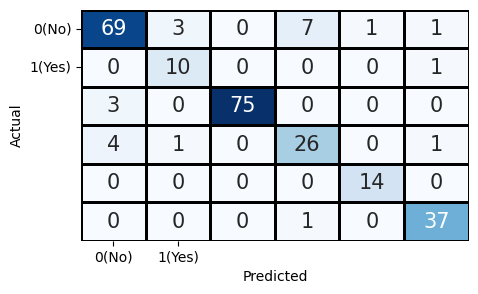

In [102]:
plt.figure(figsize = (5, 3))
sns.heatmap(confusion_matrix(y_test5, y_test_pred), cmap = 'Blues',
            cbar = False, annot = True, annot_kws = {'size' : 15},
            fmt = '.0f', xticklabels = ['0(No)', '1(Yes)'], yticklabels = ['0(No)', '1(Yes)'],
            linecolor = 'k', linewidths = 0.8)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [68]:
x_train6, x_test6, y_train6, y_test6 = split_dataset(
    df_clear2, df_target2['Type'], test_ratio = 0.2, select=1, upsampling=1)

print('훈련 데이터 shape:', x_train6.shape, y_train6.shape)
print('테스트 데이터 shape:', x_test6.shape, y_test6.shape)

print(y_train6.value_counts(normalize=True))


훈련 데이터 shape: (1940, 20) (1940,)
테스트 데이터 shape: (254, 20) (254,)
5    0.173711
1    0.172165
4    0.166495
0    0.165464
2    0.163918
3    0.158247
Name: Type, dtype: float64


In [71]:
rf_random_model = RandomForestClassifier(random_state=42,
                                         class_weight='balanced',
                                         n_jobs=-1)

param_dist = {
    'n_estimators': randint(250, 500), # 이 값을 늘리면 더 많은 트리를 사용하여 예측을 평균화하므로 일반화 성능을 향상시킬 수 있다.
    'max_depth': randint(10, 30), # 작은 값으로 설정하면 트리의 복잡성이 줄어들어 과적합을 방지
    'min_samples_split': randint(2, 10), # 큰 값으로 설정하면 과적합을 방지하는데 도움
    'min_samples_leaf': randint(2, 10), # 큰 값으로 설정하면 과적합을 방지하는데 도움
    'max_features' : randint(2, 20), # 특성 수를 제한하여 과적합을 줄일 수 있다.
    'bootstrap' : [True, False] # True로 설정하면 bagging이 활성화되어 일반화 성능을 향상시킬 수 있다.
}

# 랜덤 서치 수행
random_search6 = RandomizedSearchCV(
    rf_random_model, param_distributions=param_dist, n_iter=300, cv=5, scoring='f1_weighted', verbose=2)

# 학습 데이터에 랜덤 서치 수행
random_search6.fit(x_train6, y_train6)

# 최적의 하이퍼파라미터와 평가 지표 출력
print("최적의 하이퍼파라미터: ", random_search6.best_params_)
print("최고 f1_score: ", random_search6.best_score_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END bootstrap=True, max_depth=20, max_features=5, min_samples_leaf=6, min_samples_split=4, n_estimators=308; total time=   2.4s
[CV] END bootstrap=True, max_depth=20, max_features=5, min_samples_leaf=6, min_samples_split=4, n_estimators=308; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=5, min_samples_leaf=6, min_samples_split=4, n_estimators=308; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=5, min_samples_leaf=6, min_samples_split=4, n_estimators=308; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=5, min_samples_leaf=6, min_samples_split=4, n_estimators=308; total time=   0.2s
[CV] END bootstrap=True, max_depth=17, max_features=3, min_samples_leaf=4, min_samples_split=4, n_estimators=270; total time=   0.2s
[CV] END bootstrap=True, max_depth=17, max_features=3, min_samples_leaf=4, min_samples_split=4, n_estimators=270; total time=   0.1s
[CV] 

In [96]:
y_test_pred = random_search6.predict(x_test6)
print("테스트 정확도: ", accuracy_score(y_test6, y_test_pred))
print("테스트 recall: ", recall_score(y_test6, y_test_pred, average='weighted'))
print("테스트 Precision: ", precision_score(y_test6, y_test_pred, average='weighted'))
print("테스트 F1-score: ", f1_score(y_test6, y_test_pred, average='weighted'))
print(classification_report(y_test6, y_test_pred))

테스트 정확도:  0.905511811023622
테스트 recall:  0.905511811023622
테스트 Precision:  0.9104027861901878
테스트 F1-score:  0.9066857678352939
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        81
           1       0.67      0.91      0.77        11
           2       1.00      0.95      0.97        78
           3       0.78      0.78      0.78        32
           4       0.93      1.00      0.97        14
           5       0.93      0.97      0.95        38

    accuracy                           0.91       254
   macro avg       0.87      0.91      0.89       254
weighted avg       0.91      0.91      0.91       254



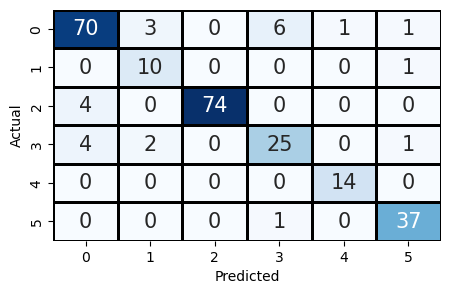

In [97]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (5, 3))
sns.heatmap(confusion_matrix(y_test6, y_test_pred), cmap = 'Blues',
            cbar = False, annot = True, annot_kws = {'size' : 15},
            fmt = '.0f',
            linecolor = 'k', linewidths = 0.8)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [72]:
x_train7, x_test7, y_train7, y_test7 = split_dataset(
    df_clear2, df_target2['Type'], test_ratio = 0.2, select=2, upsampling=None)

print('훈련 데이터 shape:', x_train7.shape, y_train7.shape)
print('테스트 데이터 shape:', x_test7.shape, y_test7.shape)

print(y_train7.value_counts(normalize=True))


훈련 데이터 shape: (1014, 20) (1014,)
테스트 데이터 shape: (254, 20) (254,)
0    0.316568
2    0.308679
5    0.149901
3    0.124260
4    0.057199
1    0.043393
Name: Type, dtype: float64


In [73]:
rf_random_model = RandomForestClassifier(random_state=42,
                                         class_weight='balanced',
                                         n_jobs=-1)

param_dist = {
    'n_estimators': randint(250, 500), # 이 값을 늘리면 더 많은 트리를 사용하여 예측을 평균화하므로 일반화 성능을 향상시킬 수 있다.
    'max_depth': randint(10, 30), # 작은 값으로 설정하면 트리의 복잡성이 줄어들어 과적합을 방지
    'min_samples_split': randint(2, 10), # 큰 값으로 설정하면 과적합을 방지하는 데 도움
    'min_samples_leaf': randint(2, 10), # 큰 값으로 설정하면 과적합을 방지하는 데 도움
    'max_features' : randint(2, 20), # 특성 수를 제한하여 과적합을 줄일 수 있다.
    'bootstrap' : [True, False] # True로 설정하면 bagging이 활성화되어 일반화 성능을 향상시킬 수 있다.
}

# 랜덤 서치 수행
random_search7 = RandomizedSearchCV(
    rf_random_model, param_distributions=param_dist, n_iter=300, cv=5, scoring='f1_weighted', verbose=2)

# 학습 데이터에 랜덤 서치 수행
random_search7.fit(x_train7, y_train7)

# 최적의 하이퍼파라미터와 평가 지표 출력
print("최적의 하이퍼파라미터: ", random_search7.best_params_)
print("최고 f1_score: ", random_search7.best_score_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END bootstrap=False, max_depth=26, max_features=4, min_samples_leaf=2, min_samples_split=6, n_estimators=439; total time=   0.2s
[CV] END bootstrap=False, max_depth=26, max_features=4, min_samples_leaf=2, min_samples_split=6, n_estimators=439; total time=   0.2s
[CV] END bootstrap=False, max_depth=26, max_features=4, min_samples_leaf=2, min_samples_split=6, n_estimators=439; total time=   0.2s
[CV] END bootstrap=False, max_depth=26, max_features=4, min_samples_leaf=2, min_samples_split=6, n_estimators=439; total time=   0.2s
[CV] END bootstrap=False, max_depth=26, max_features=4, min_samples_leaf=2, min_samples_split=6, n_estimators=439; total time=   0.2s
[CV] END bootstrap=False, max_depth=12, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=317; total time=   0.2s
[CV] END bootstrap=False, max_depth=12, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=317; total time=   0

In [81]:
y_test_pred = random_search7.predict(x_test7)
print("테스트 정확도: ", accuracy_score(y_test7, y_test_pred))
print("테스트 recall: ", recall_score(y_test7, y_test_pred, average='weighted'))
print("테스트 Precision: ", precision_score(y_test7, y_test_pred, average='weighted'))
print("테스트 F1-score: ", f1_score(y_test7, y_test_pred, average='weighted'))

테스트 정확도:  0.9173228346456693
테스트 recall:  0.9173228346456693
테스트 Precision:  0.9199163401799701
테스트 F1-score:  0.9181611229154635


In [74]:
x_train8, x_test8, y_train8, y_test8 = split_dataset(
    df_clear2, df_target2['Type'], test_ratio = 0.2, select=2, upsampling=1)

print('훈련 데이터 shape:', x_train8.shape, y_train8.shape)
print('테스트 데이터 shape:', x_test8.shape, y_test8.shape)

print(y_train8.value_counts(normalize=True))


훈련 데이터 shape: (1940, 20) (1940,)
테스트 데이터 shape: (254, 20) (254,)
5    0.173711
1    0.172165
4    0.166495
0    0.165464
2    0.163918
3    0.158247
Name: Type, dtype: float64


In [75]:
rf_random_model = RandomForestClassifier(random_state=42,
                                         class_weight='balanced',
                                         n_jobs=-1)

param_dist = {
    'n_estimators': randint(250, 500), # 이 값을 늘리면 더 많은 트리를 사용하여 예측을 평균화하므로 일반화 성능을 향상시킬 수 있다.
    'max_depth': randint(10, 30), # 작은 값으로 설정하면 트리의 복잡성이 줄어들어 과적합을 방지
    'min_samples_split': randint(2, 10), # 큰 값으로 설정하면 과적합을 방지하는 데 도움
    'min_samples_leaf': randint(2, 10), # 큰 값으로 설정하면 과적합을 방지하는 데 도움
    'max_features' : randint(2, 20), # 특성 수를 제한하여 과적합을 줄일 수 있다.
    'bootstrap' : [True, False] # True로 설정하면 bagging이 활성화되어 일반화 성능을 향상시킬 수 있다.
}

# 랜덤 서치 수행
random_search8 = RandomizedSearchCV(
    rf_random_model, param_distributions=param_dist, n_iter=300, cv=5, scoring='f1_weighted', verbose=2)

# 학습 데이터에 랜덤 서치 수행
random_search8.fit(x_train8, y_train8)

# 최적의 하이퍼파라미터와 평가 지표 출력
print("최적의 하이퍼파라미터: ", random_search8.best_params_)
print("최고 f1_score: ", random_search8.best_score_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END bootstrap=False, max_depth=29, max_features=6, min_samples_leaf=6, min_samples_split=9, n_estimators=286; total time=   0.2s
[CV] END bootstrap=False, max_depth=29, max_features=6, min_samples_leaf=6, min_samples_split=9, n_estimators=286; total time=   0.2s
[CV] END bootstrap=False, max_depth=29, max_features=6, min_samples_leaf=6, min_samples_split=9, n_estimators=286; total time=   0.2s
[CV] END bootstrap=False, max_depth=29, max_features=6, min_samples_leaf=6, min_samples_split=9, n_estimators=286; total time=   0.2s
[CV] END bootstrap=False, max_depth=29, max_features=6, min_samples_leaf=6, min_samples_split=9, n_estimators=286; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=12, min_samples_leaf=8, min_samples_split=5, n_estimators=459; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=12, min_samples_leaf=8, min_samples_split=5, n_estimators=459; total time=   0.3

In [82]:
y_test_pred = random_search8.predict(x_test8)
print("테스트 정확도: ", accuracy_score(y_test8, y_test_pred))
print("테스트 recall: ", recall_score(y_test8, y_test_pred, average='weighted'))
print("테스트 Precision: ", precision_score(y_test8, y_test_pred, average='weighted'))
print("테스트 F1-score: ", f1_score(y_test8, y_test_pred, average='weighted'))

테스트 정확도:  0.9094488188976378
테스트 recall:  0.9094488188976378
테스트 Precision:  0.9137160293043866
테스트 F1-score:  0.9104278941232563


In [100]:
grid_search_model = RandomForestClassifier(random_state=42,
                                         class_weight='balanced',
                                         bootstrap=False,
                                         n_jobs=-1)

param_grid = {
'n_estimators': [300, 350, 413, 450], # 결정 트리 개수 후보
'max_depth': [13, 14, 15, 17], # 최대 깊이 후보
'min_samples_split': [2, 3, 4, 5], # 노드를 분할하기 위한 최소 샘플 수 후보
'min_samples_leaf': [2, 3, 4, 5], # 리프 노드에 필요한 최소 샘플 수 후보
'max_features': [4, 6, 8, 10]
}

gs_model8 = GridSearchCV(grid_search_model, param_grid, cv=5, scoring='f1_weighted', verbose=2)


# 학습 데이터에 랜덤 서치 수행
gs_model8.fit(x_train8, y_train8)

# 최적의 하이퍼파라미터와 평가 지표 출력
print("최적의 하이퍼파라미터: ", gs_model8.best_params_)
print("최고 f1_score: ", gs_model8.best_score_)

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits
[CV] END max_depth=13, max_features=4, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.8s
[CV] END max_depth=13, max_features=4, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END max_depth=13, max_features=4, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END max_depth=13, max_features=4, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END max_depth=13, max_features=4, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END max_depth=13, max_features=4, min_samples_leaf=2, min_samples_split=2, n_estimators=350; total time=   0.2s
[CV] END max_depth=13, max_features=4, min_samples_leaf=2, min_samples_split=2, n_estimators=350; total time=   0.2s
[CV] END max_depth=13, max_features=4, min_samples_leaf=2, min_samples_split=2, n_estimators=350; total time=   0.2s

In [101]:
y_test_pred = random_search8.predict(x_test8)
print("테스트 정확도: ", accuracy_score(y_test8, y_test_pred))
print("테스트 recall: ", recall_score(y_test8, y_test_pred, average='weighted'))
print("테스트 Precision: ", precision_score(y_test8, y_test_pred, average='weighted'))
print("테스트 F1-score: ", f1_score(y_test8, y_test_pred, average='weighted'))

테스트 정확도:  0.9094488188976378
테스트 recall:  0.9094488188976378
테스트 Precision:  0.9137160293043866
테스트 F1-score:  0.9104278941232563
